# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from datetime import datetime,date

## Assess Data: Visually and Programmatically

### 1. Assess portfolio dataframe for tidyness and quality

In [4]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [9]:
portfolio.shape

(10, 6)

There are 10 rows and 6 columns. 

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


Difficulty is between 0 to 20. 

Reward values are between 0 to 10. 

Duration is between 3 days to 10 days. 

0 difficulty and 0 reward = informational 

In [17]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

**1. Channels should be split in seperate columns with flag 1,0 instead of single column with multiple values.** 


### 2. Assess profile dataframe for tidyness and quality

In [3]:
profile.head(3)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


In [12]:
profile.shape

(17000, 5)

There are 17000 profiles of customers. 

In [21]:
#check for duplicates

profile.duplicated().sum()

0

In [23]:
#check for null values

profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

There are 2175 entries where we have no gender or income information of the customer.

In [26]:
profile[profile.income.isnull()].age.describe()

count    2175.0
mean      118.0
std         0.0
min       118.0
25%       118.0
50%       118.0
75%       118.0
max       118.0
Name: age, dtype: float64

Customers where the income is null had age set to 118. 

In [13]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


**1. Customer records with 118 age looks incorrect and should be cleaned out.** 
<br>**2. became_member_on should be converted to a valid date format.** 

### 3. Assess transcript dataframe for tidyness and quality

In [40]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [14]:
transcript.shape

(306534, 4)

There are 306534 rows in the transcript data

In [16]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [31]:
#time range

transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [42]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [36]:
transcript.astype(str).duplicated().sum()

397

In [39]:
duplicates=transcript.astype(str).duplicated(keep=False)
print(transcript[duplicates])

                  event                            person  time  \
66122   offer completed  3dde94fa581145cb9f206624f1a94d5a   168   
66123   offer completed  3dde94fa581145cb9f206624f1a94d5a   168   
66782   offer completed  e9fb6ed2cecb4980ba98c86abc9c91e3   168   
66783   offer completed  e9fb6ed2cecb4980ba98c86abc9c91e3   168   
67613   offer completed  a7dc060f6fc94ca7bf71fbb188187dca   168   
67614   offer completed  a7dc060f6fc94ca7bf71fbb188187dca   168   
68561   offer completed  30478a4c1e884a63a822aa87b833ed7a   168   
68562   offer completed  30478a4c1e884a63a822aa87b833ed7a   168   
69217   offer completed  84fb57a7fe8045a8bf6236738ee73a0f   168   
69218   offer completed  84fb57a7fe8045a8bf6236738ee73a0f   168   
76756   offer completed  7cd890d4d691465aa25b683943a1c056   186   
76757   offer completed  7cd890d4d691465aa25b683943a1c056   186   
79436   offer completed  1abeb816d9fa49b4b5b5ae51bc3d24c3   198   
79437   offer completed  1abeb816d9fa49b4b5b5ae51bc3d24c3   19

There are around 397 rows with duplicate rows. 

**1. event column can be split to three columns : transaction, offer_received, offer_viewed and offer_completed** 
<br>**2. value field can be split into columns offer_id, amount, reward with corresponding values.**
<br>**3. After step 2, the cleaned rows need to be reassessed for duplicates.**
<br>**4. Convert time to days for easy comparison.**

## Clean  Data

In [3]:
#Make copy of original data
portfolio_df = portfolio.copy()

In [4]:
#Make copy of original data
profile_df = profile.copy()

In [5]:
#Make copy of original data
transcript_df = transcript.copy()

#### Define

Channels should be split in seperate columns with flag 1,0 instead of single column with multiple values.

#### Code

In [6]:
portfolio_df['web'] = portfolio_df.channels.apply(lambda x: 1 if 'web' in x else 0)
portfolio_df['email'] = portfolio_df.channels.apply(lambda x: 1 if 'email' in x else 0)
portfolio_df['social'] = portfolio_df.channels.apply(lambda x: 1 if 'social' in x else 0)
portfolio_df['mobile'] = portfolio_df.channels.apply(lambda x: 1 if 'mobile' in x else 0)

#drop channels column
portfolio_df.drop(['channels'], axis=1, inplace=True)

#### Test

In [8]:
portfolio_df.head()

,difficulty,duration,id,offer_type,reward,web,email,social,mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


#### Define

convert time to days

#### Code

In [7]:
#convert time to days
transcript_df['time'] = np.round(transcript_df['time'] / 24,2)

#### Test

In [161]:
transcript_df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


#### Define

Customer records with 118 age needs to be dropped

#### Code

In [8]:
profile_df = profile_df.query('age < 118')

#### Test

In [9]:
profile_df.query('age == 118').head()

,age,became_member_on,gender,id,income


#### Define

became_member_on should be converted to a valid date format.

#### Code

In [9]:
profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'].astype(str), format='%Y%m%d')

#### Test

In [113]:
profile_df.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


#### Define

event column can be split to four columns : offer_received, offer_viewed , transaction and offer_completed

#### Code

In [10]:
transcript_df['offer_received'] = transcript_df['event'].apply(lambda x: 1 if x == 'offer received' else 0)
transcript_df['offer_viewed'] = transcript_df['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)
transcript_df['offer_completed'] = transcript_df['event'].apply(lambda x: 1 if x == 'offer completed' else 0)

In [11]:
transcript_df['transaction'] = transcript_df['event'].apply(lambda x: 1 if x == 'transaction' else 0)

In [12]:
transcript_df.drop(['event'], axis=1, inplace=True)

#### Test

In [35]:
transcript_df.head()

,person,time,value,offer_received,offer_viewed,offer_completed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1,0,0,0


#### Define

value field can be split into columns offer id, amount, reward with corresponding values.

#### Code

In [13]:
values = pd.DataFrame(transcript_df['value'].tolist());

In [14]:
values.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


We need to merge columns offer_id and offer id

In [16]:
values[(~values['offer id'].isna() & ~values['offer_id'].isna())].head()

,amount,offer id,offer_id,reward


In [17]:
#combine the offer_id and offer id column 
values["offer_id"].fillna(values["offer id"], inplace=True)

In [45]:
values.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [15]:
#drop the offer id column
values.drop(['offer id'], axis=1, inplace=True);

In [16]:
#concat the values columns
transcript_df = pd.concat([transcript_df, values], axis=1, sort=False)

In [17]:
#drop value
transcript_df.drop(['value'], axis=1, inplace=True)

#### Test

In [49]:
transcript_df.head()

,person,time,offer_received,offer_viewed,offer_completed,transaction,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


#### Define

Drop duplicate rows.

#### Code

In [18]:
transcript_df.drop_duplicates(inplace=True)

#### Test

In [20]:
transcript_df.duplicated().sum()

0

#### Define

Merge portfolio and transcript datasets on offer_id.

#### Code

In [19]:
portfolio_df.rename(columns={'id':'offer_id'},inplace=True)

In [56]:
transcript_df.dtypes

person              object
time                 int64
offer_received       int64
offer_viewed         int64
offer_completed      int64
transaction          int64
amount             float64
offer_id            object
reward             float64
dtype: object

In [20]:
transcript_df = transcript_df.merge(portfolio_df, how='left',on='offer_id')

In [21]:
#drop reward from portfolio and rename reward_x into reward
transcript_df.rename(columns={'reward_x':'reward'},inplace=True)

transcript_df.drop(columns={'reward_y'},inplace=True)

#### Test

In [97]:
transcript_df.head()

,person,time,offer_received,offer_viewed,offer_completed,transaction,amount,offer_id,reward,difficulty,duration,offer_type,web,email,social,mobile
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,discount,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,5.0,bogo,1.0,1.0,1.0,1.0


## Explore Data

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

### 1. Cumulative count of members over time

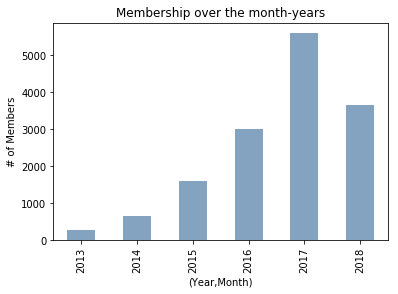

In [151]:
ax = profile_df.became_member_on.groupby([profile_df["became_member_on"].dt.year]).count()
ax.plot('bar', title='Membership over the years',color=(0.2, 0.4, 0.6, 0.6) )

plt.xlabel("(Year,Month)")
plt.ylabel("# of Members")
plt.ylim(0, )

plt.draw()

2017 was the most successful year in getting members. The drop in members in 2018 looks unusual.

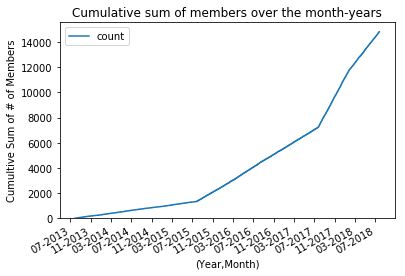

In [23]:
tmp = profile_df[["became_member_on"]].copy()
tmp['count'] = 1
tmp.set_index('became_member_on', inplace=True)
ax = tmp.sort_index().cumsum().plot()

# Define the date format
date_form = DateFormatter("%m-%Y")
ax.xaxis.set_major_formatter(date_form)
# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))


plt.xlabel("(Year,Month)")
plt.ylabel("Cumultive Sum of # of Members")
plt.ylim(0, )
plt.title('Cumulative sum of members over the month-years');


Over time the number of customer memberships has increased exponentially from 2013 to 2019. there are however, 2 dips in the number of customers count, one in July 2015 and another one in July 2017.

### 2. Distribution of member's income 

In [22]:
profile_df['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

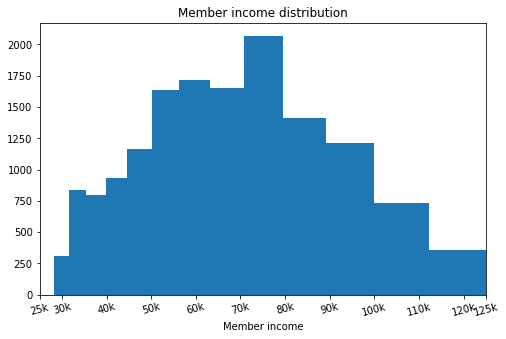

In [98]:
bins = 10 ** np.arange(4, np.log10(profile_df['income'].max())+ 0.1, 0.05)

plt.figure(figsize=[8, 5])
y,x,_ = plt.hist(data = profile_df, x = 'income', bins = bins)

plt.xticks([2.5e4, 3e4, 4e4, 5e4,6e4,7e4,8e4,9e4,10e4,11e4,12e4,12.5e4], ['25k','30k', '40k','50k','60k','70k','80k','90k','100k','110k','120k','125k'],rotation='15')
plt.xlabel('Member income')
plt.xlim(2.5e4,12.5e4)

plt.title('Member income distribution')

plt.show()

Member income distribution looks multimodal in nature.There is a huge peak between 68k and a mean income value of 65k for the customers. However, we observe a range of income values from 30k to 120k. 

It makes sense to group income of members:

<49000 : Low income
<br> >= 49000 and <= 64000 : Mid-low income
<br> >= 64000 and <= 80000 : Mid-high income
<br> >80000 : High income

In [23]:
profile_df.loc[(profile_df.income < 49000),  'income_group'] = 'Low'
profile_df.loc[(profile_df.income >= 49000) & (profile_df.income <= 80000),  'income_group'] = 'Mid'
profile_df.loc[(profile_df.income >= 80000),  'income_group'] = 'High'

In [145]:
profile_df.income_group.value_counts()

Mid     7484
High    3717
Low     3624
Name: income_group, dtype: int64

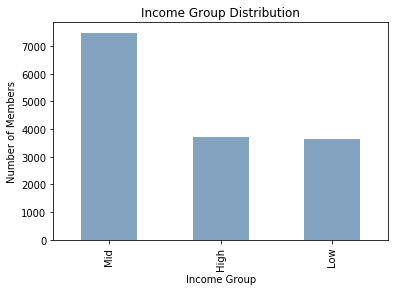

In [24]:
profile_df['income_group'].value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6))
plt.ylabel('Number of Members')
plt.xlabel('Income Group')
plt.title('Income Group Distribution');

More than 50% of members have mid-level income,, 25% have high income and 24.4% have low income.

In [147]:
100 *(profile_df['income_group'].value_counts()/profile_df['income_group'].shape[0])

Mid     50.482293
High    25.072513
Low     24.445194
Name: income_group, dtype: float64

### 3. Age distribution per gender of members

In [64]:
profile_df['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

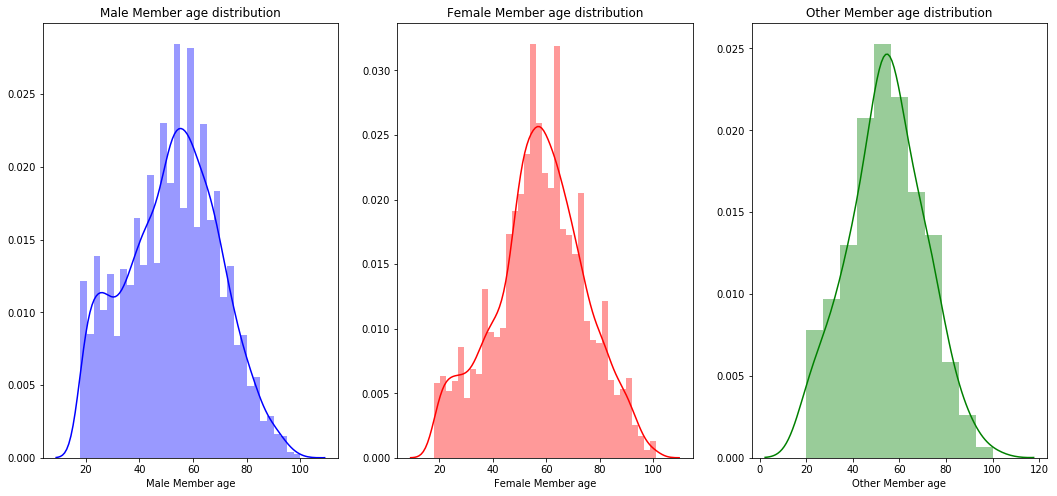

In [42]:
plt.figure(figsize=[18, 8])
plt.subplot(131)
sb.distplot(profile_df.query("gender == 'M'")['age'],color='blue')
plt.xlabel('Male Member age')
plt.title('Male Member age distribution');
plt.subplot(132)
sb.distplot(profile_df.query("gender == 'F'")['age'],color='red');
plt.xlabel('Female Member age')
plt.title('Female Member age distribution');
plt.subplot(133)
sb.distplot(profile_df.query("gender == 'O'")['age'],color='green');
plt.xlabel('Other Member age')
plt.title('Other Member age distribution');

The age distribution of the male members look bimodal in nature with first peak at 55years and a smaller peak at 30 years.

The age distribution of the female members look unimodal in nature with close peak at 58 years.


It makes sense to group age into generations:
1. 6-24 : Gen Z
2. 25-40 : Millennials
3. 41-56 : Gen X
4. 57-75 : Baby Boomers
5. 75+ : Gen Silent 

In [25]:
profile_df.loc[(profile_df.age < 24),  'age_generation'] = 'Gen Z'
profile_df.loc[(profile_df.age >= 25) & (profile_df.age <= 40),  'age_generation'] = 'Millennials'
profile_df.loc[(profile_df.age >= 41) & (profile_df.age <= 56),  'age_generation'] = 'Gen X'
profile_df.loc[(profile_df.age >= 57) & (profile_df.age <= 75),  'age_generation'] = 'Baby Boomers'
profile_df.loc[(profile_df.age >= 56),  'age_generation'] = 'Gen Silent'

In [22]:
profile_df.head()

,age,became_member_on,gender,id,income,age_generation,income_group
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,Gen X,High
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Gen Silent,High
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,Gen Silent,Mid
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,Gen Silent,Mid
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,Gen Silent,Mid


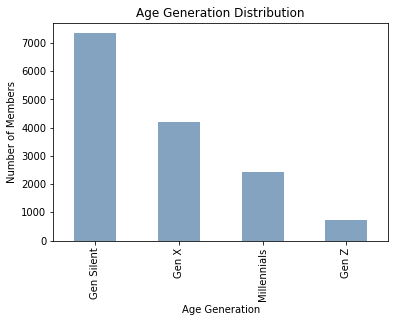

In [38]:
profile_df['age_generation'].value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6))
plt.ylabel('Number of Members')
plt.xlabel('Age Generation')
plt.title('Age Generation Distribution');

In [138]:
100 *(profile_df['age_generation'].value_counts()/profile_df['age_generation'].shape[0])

Gen Silent     49.490725
Gen X          28.236088
Millennials    16.364250
Gen Z           4.971332
Name: age_generation, dtype: float64

Around 49.5% of members are from silent generation, 28.23% are generation X and 16% are Millennials.And only 4% members are GenZ

In [34]:
profile_df['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

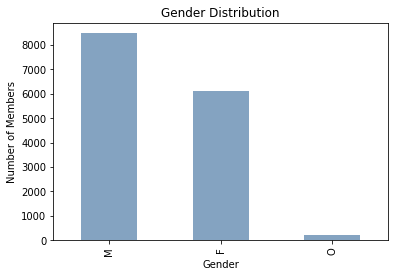

In [121]:
profile_df['gender'].value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6))
plt.ylabel('Number of Members')
plt.xlabel('Gender')
plt.title('Gender Distribution');

Most of the members are men: 8484 members, 6129 members are female and 212 are others. 

### 4. Percentage of offers received, viewed and completed. 

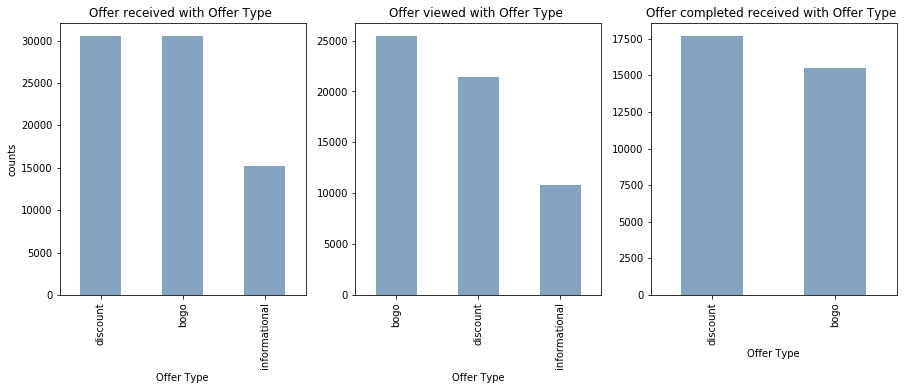

In [119]:
plt.subplot(131)
transcript_df[transcript_df['offer_received'] == 1].offer_type.value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6), figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

plt.subplot(132)
transcript_df[transcript_df['offer_viewed'] == 1].offer_type.value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6), figsize=(15,5))
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type ');

plt.subplot(133)
transcript_df[transcript_df['offer_completed'] == 1].offer_type.value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6), figsize=(15,5))
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type ');

In [124]:
transcript_df[transcript_df['offer_viewed'] == 1].offer_type.value_counts()/transcript_df[transcript_df['offer_viewed'] == 1].offer_type.count()

bogo             0.440866
discount         0.371503
informational    0.187631
Name: offer_type, dtype: float64

In [125]:
transcript_df[transcript_df['offer_completed'] == 1].offer_type.value_counts()/transcript_df[transcript_df['offer_completed'] == 1].offer_type.count()

discount    0.532849
bogo        0.467151
Name: offer_type, dtype: float64

1. Customers received discount and bogo offers equally.
2. bogo offers were viewed 8% times more than discount and 26% more than informational offers.
3. Around 53% of total offers completed were discount and 46% were bogo.

#### Offer View rate for all bogo

In [137]:
100*(transcript_df.loc[(transcript_df['offer_type'] == 'bogo') & (transcript_df['offer_viewed']== 1)].offer_id.count()/transcript_df.loc[(transcript_df['offer_type'] == 'bogo') & (transcript_df['offer_received']== 1)].offer_id.count())

83.442080068198948

#### Offer View rate for all discount

83.44% of bogo offers are viewed. 

In [138]:
100*(transcript_df.loc[(transcript_df['offer_type'] == 'discount') & (transcript_df['offer_viewed']== 1)].offer_id.count()/transcript_df.loc[(transcript_df['offer_type'] == 'discount') & (transcript_df['offer_received']== 1)].offer_id.count())

70.212487312968591

70.21% of discount offers were viewed. 

#### Offer completion rate for all bogo

In [142]:
100*(transcript_df.loc[(transcript_df['offer_type'] == 'bogo') & (transcript_df['offer_completed']== 1)].offer_id.count()/transcript_df.loc[(transcript_df['offer_type'] == 'bogo') & (transcript_df['offer_received']== 1)].offer_id.count())

50.824617200563949

Around 50.82% bogo offers were completed out of those received.

#### Offer completion rate for all discount

In [143]:
100*(transcript_df.loc[(transcript_df['offer_type'] == 'discount') & (transcript_df['offer_completed']== 1)].offer_id.count()/transcript_df.loc[(transcript_df['offer_type'] == 'discount') & (transcript_df['offer_received']== 1)].offer_id.count())

57.888877975313491

Around 57.88% discount offers were completed out of those viewed.

### 5. Distribution of taken by customers to achieve offer

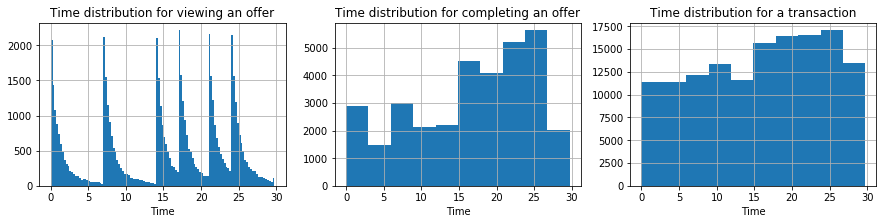

In [195]:
plt.figure(figsize=[15, 3])

plt.title('Member income distribution')

bins = np.arange(0,30,0.25)

plt.subplot(131)
transcript_df[transcript_df['offer_viewed'] == 1].time.hist(bins=bins);
plt.xlabel('Time')
plt.title('Time distribution for viewing an offer');

plt.subplot(132)
transcript_df[transcript_df['offer_completed'] == 1].time.hist();
plt.xlabel('Time')
plt.title('Time distribution for completing an offer');

plt.subplot(133)
transcript_df[transcript_df['transaction'] == 1].time.hist();
plt.xlabel('Time')
plt.title('Time distribution for a transaction');


Time distribution shows multimodal distribution for all three actions. We cannot 

## Master Dataset for machine learning model 

In [26]:
profile_df.rename(columns={'id':'person'},inplace=True)

In [27]:
#combine the profile and transcript tables
master_df = transcript_df.merge(profile_df, how='inner',on='person')
master_df.head()

,person,time,offer_received,offer_viewed,offer_completed,transaction,amount,offer_id,reward,difficulty,...,web,email,social,mobile,age,became_member_on,gender,income,income_group,age_generation
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,1,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
1,78afa995795e4d85b5d9ceeca43f5fef,0.25,0,1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
2,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,0,0,1,19.89,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
3,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,0,1,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,...,1.0,1.0,0.0,1.0,75,2017-05-09,F,100000.0,High,Gen Silent
4,78afa995795e4d85b5d9ceeca43f5fef,6.00,0,0,0,1,17.78,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent


In [41]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272388 entries, 0 to 272387
Data columns (total 21 columns):
person              272388 non-null object
time                272388 non-null float64
offer_received      272388 non-null int64
offer_viewed        272388 non-null int64
offer_completed     272388 non-null int64
transaction         272388 non-null int64
amount              123957 non-null float64
offer_id            148431 non-null object
reward              32070 non-null float64
difficulty          148431 non-null float64
duration            148431 non-null float64
offer_type          148431 non-null object
web                 148431 non-null float64
email               148431 non-null float64
social              148431 non-null float64
mobile              148431 non-null float64
age                 272388 non-null int64
became_member_on    272388 non-null datetime64[ns]
gender              272388 non-null object
income              272388 non-null float64
age_generation   

In [28]:
#check actions of a single user
pd.set_option('display.max_columns', 129)
pd.set_option('display.max_rows', 129)
master_df[master_df['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,time,offer_received,offer_viewed,offer_completed,transaction,amount,offer_id,reward,difficulty,duration,offer_type,web,email,social,mobile,age,became_member_on,gender,income,income_group,age_generation
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
1,78afa995795e4d85b5d9ceeca43f5fef,0.25,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
2,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,0,0,1,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
3,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,0,1,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,75,2017-05-09,F,100000.0,High,Gen Silent
4,78afa995795e4d85b5d9ceeca43f5fef,6.00,0,0,0,1,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
5,78afa995795e4d85b5d9ceeca43f5fef,7.00,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
6,78afa995795e4d85b5d9ceeca43f5fef,9.00,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
7,78afa995795e4d85b5d9ceeca43f5fef,9.25,0,0,0,1,19.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
8,78afa995795e4d85b5d9ceeca43f5fef,10.00,0,0,0,1,29.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent
9,78afa995795e4d85b5d9ceeca43f5fef,15.75,0,0,0,1,23.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2017-05-09,F,100000.0,High,Gen Silent


## Building Prediction Model

Predict a customer response of offer completion.

In [100]:
#copy 
df=master_df.copy()

In [101]:
#set codes for user actions offer_completed and offer_viewed
df.loc[(df.offer_completed == 1),  'action'] = 1
df.loc[(df.offer_viewed == 1),  'action'] = 2

#when action is NaN it points to transaction or offer received which is not required
df.dropna(subset=['action'],inplace=True)

In [102]:
#convert became_member_on to numeric to get membership tenure in days
df['tenure'] = (datetime.today().date() - pd.to_datetime(df['became_member_on'],format='%Y%m%d').dt.date).dt.days

In [104]:
#let us drop ore columns not relevant to our question
df.drop(columns=['age','offer_viewed','offer_completed','offer_id','income','became_member_on','person','offer_received','transaction','offer_viewed','transaction','amount','reward'],inplace=True)

In [105]:
#let us look at all the numerical variables we have
df.head()

,time,difficulty,duration,offer_type,web,email,social,mobile,gender,income_group,age_generation,action,tenure
1,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,High,Gen Silent,2.0,1409
3,5.50,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,High,Gen Silent,1.0,1409
6,9.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,High,Gen Silent,2.0,1409
11,17.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,High,Gen Silent,2.0,1409
14,21.25,10.0,7.0,bogo,0.0,1.0,1.0,1.0,F,High,Gen Silent,1.0,1409


In [106]:
#fill nan with 0
df.fillna(value=0,inplace=True)

#### Features 

<br>**Categorical features**
<br>offer_type
<br>web
<br>email
<br>social
<br>mobile
<br>gender
<br>income_group
<br>age_generation
<br>
<br>
<br>**Quantitative features**
<br>time
<br>difficulty
<br>duration
<br>tenure
<br>
<br>
<br>**Variable to predict**
<br>action : completed=1,viewed=2


In [34]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
            
    Reference: Notebook + Quiz: Putting it all Together
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [44]:
#create dummy columns for categorical fields
cat_cols={'age_generation','income_group','offer_type','gender'}

df=create_dummy_df(df, cat_cols, False)

In [46]:
#feature list
X = df.drop(columns=['offer_completed']).fillna(value=0)

#variable to predict
Y=df['offer_completed']

In [47]:
#feature list
X.head()

,time,offer_received,offer_viewed,transaction,amount,reward,difficulty,duration,web,email,social,mobile,tenure,offer_type_discount,gender_M,gender_O,income_group_Low,income_group_Mid,age_generation_Gen X,age_generation_Gen Z,age_generation_Millennials
0,0.00,1,0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1409,0,0,0,0,0,0,0,0
1,0.25,0,1,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1409,0,0,0,0,0,0,0,0
2,5.50,0,0,1,19.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1409,0,0,0,0,0,0,0,0
3,5.50,0,0,0,0.00,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1409,0,0,0,0,0,0,0,0
4,6.00,0,0,1,17.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1409,0,0,0,0,0,0,0,0


In [48]:
#variable to predict
Y.head()

0    0
1    0
2    0
3    1
4    0
Name: offer_completed, dtype: int64

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

In [107]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [108]:
#function to predict model score
def predict_score(model):
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 4)

As the field to be predicted is categorical in nature, I will select Logistic Regression and K Neighbors classifier to predict the member action.

### Logistic Regression Model

In [109]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy : {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(logreg)}%')

Accuracy : 100.0%.
Prediction Accuracy: 100.0%


### K-neighbors Classifer

In [110]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy : {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(knn)}%')

Accuracy : 100.0%.
Prediction Accuracy: 99.9745%


The K-neighbors classifier gives prediction accuracy a bit lower than Logistic Regression Model. Logistic Regression model looks like an overfitting model with 100% prediction accuracy. K-neighbors Classifier is still better than the first. Any improvement on the model could result in overfitting of the model.